# Models and Estimation

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore', FutureWarning) # Seaborn triggers warnings in scipy
%matplotlib inline

In [108]:
# Configure nice plotting defaults - (this must be done in a cell separate
# from %matplotlib call)
plt.style.use('seaborn')
sns.set_context('talk', font_scale=1.4)
plt.rcParams['figure.figsize'] = (10, 7)

We're also going to use plotly for interactive plots.

In [109]:
import plotly.offline as py
py.init_notebook_mode(connected=True) # True if online -> smaller notebooks without plotly.js

import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf

cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

## Mock Data and Simple Loss Functions
Over here we are making mock data with just 4 observations. The purpose here is to visualize how the loss function looks, why we need to minimize it, and what effect extreme values have on different loss functions.

To "model" this data, we are assuming an extremely simple case where we say that we will use a single number $\theta$ to estimate the data. In mathematical terms, our model is $y = \theta$. Our question now is how the loss function changes with respect to this $\theta$, and how to choose the best $\theta$

In [110]:
data = [5, 7, 8, 9]

In [111]:
def abs_loss(est, y_obs):
    return np.abs(y_obs - est)

In [112]:
def squared_loss(est, y_obs):
    return (est - y_obs)**2

In [113]:
def avg_absolute_loss(est, data):
    return np.mean(np.array([abs_loss(est, y_obs) for y_obs in data]), axis=0)

In [114]:
def avg_squared_loss(est, data):
    return np.mean(np.array([squared_loss(est, y_obs) for y_obs in data]), axis=0)

In [115]:
# Suppose we choose theta to be 8, what is the average absolute loss?
avg_absolute_loss(8, data)

1.25

In [116]:
# What is the average square loss?
avg_squared_loss(8, data)

2.75

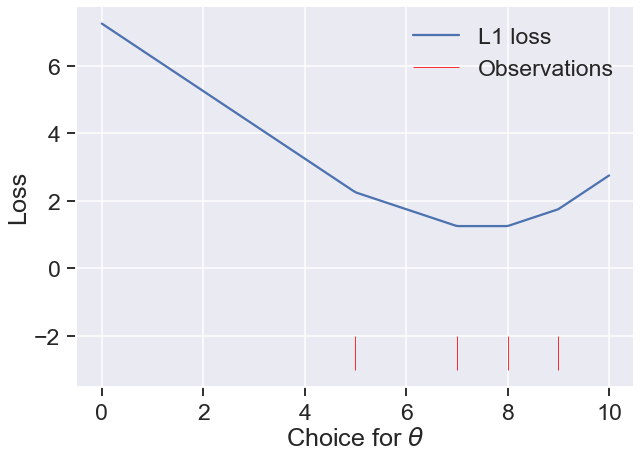

In [117]:
thetas = np.linspace(0, 10, 200)
loss = avg_absolute_loss(thetas, data)
plt.plot(thetas, loss, label="L1 loss")
plt.vlines(data, -3, -2, colors="r", linewidth=0.8, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l9_abs_loss.png", dpi=300)

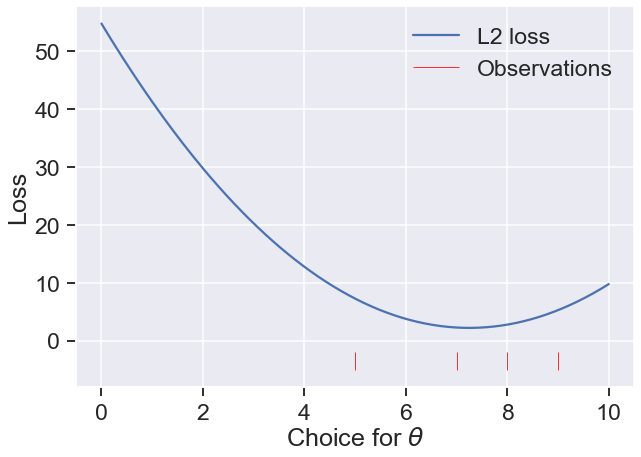

In [118]:
thetas = np.linspace(0, 10, 200)
loss = avg_squared_loss(thetas, data)
plt.plot(thetas, loss, label = "L2 loss")
plt.vlines(data, -5, -2, colors="r", linewidth=0.8, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l9_squared_loss.png", dpi=300)


### Effect of outliers

For the L2 loss, a single outlier can cause huge changes in the optimal theta.

In [119]:
# 100 is an outlier for the overall data
data2 = [5, 7, 8, 9, 100]

From our discussion in class, we know that the mean of the data is analytically the $\theta$ for which we get the minimum value of loss. As you can see below, the mean changes drastically when an outlier is introduced.

In [120]:
np.mean(data2)

25.8

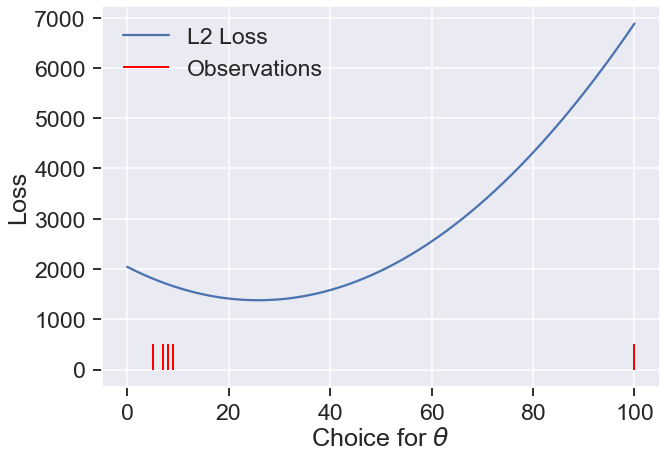

In [121]:
thetas = np.linspace(0, 100, 200)
loss = avg_squared_loss(thetas, data2)
plt.plot(thetas, loss, label="L2 Loss")
plt.vlines(data2, 0, 500, colors="r", linewidth=2, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l9_squared_loss_outlier.png", dpi=300)

As you can see above, the minimum value has significally moved ahead due to the addition of the outlier (keep in mind the difference in scale between this graph and the previous graph)

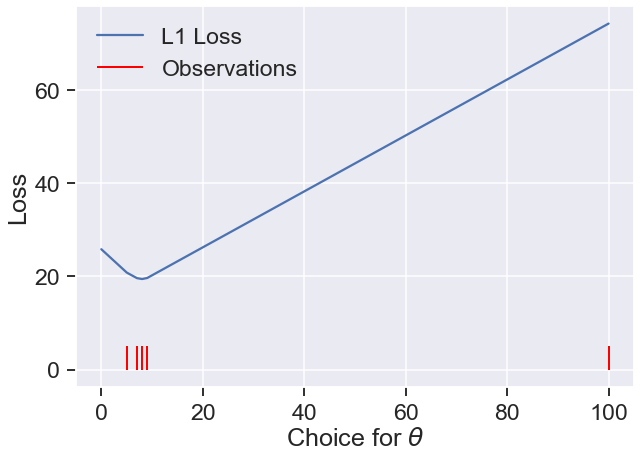

In [122]:
thetas = np.linspace(0, 100, 200)
loss = avg_absolute_loss(thetas, data2)
plt.plot(thetas, loss, label="L1 Loss")
plt.vlines(data2, 0, 5, colors="r", linewidth=2, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l9_absolute_loss_outlier.png", dpi=300)

The L1 loss, on the other hand, is less affected by the outlier as compared to the L2 loss

### The Huber Loss
You can find details of Huber Loss in the slides as well, but it aims to strike a balance between the L1 and L2 losses. An important thing about the Huber loss is the value of $\alpha$, which essentially controls the balance between L1 loss and L2 loss

In [123]:
def huber_loss(est, y_obs, alpha = 1):
    d = abs_loss(est, y_obs)
    return np.where(d < alpha, 
                    squared_loss(est, y_obs) / 2.0,
                    alpha * (d - alpha / 2.0))

In [124]:
def avg_huber_loss(est, data, alpha = 1):
    return np.mean(np.array([huber_loss(est, y_obs, alpha) for y_obs in data]), axis=0)

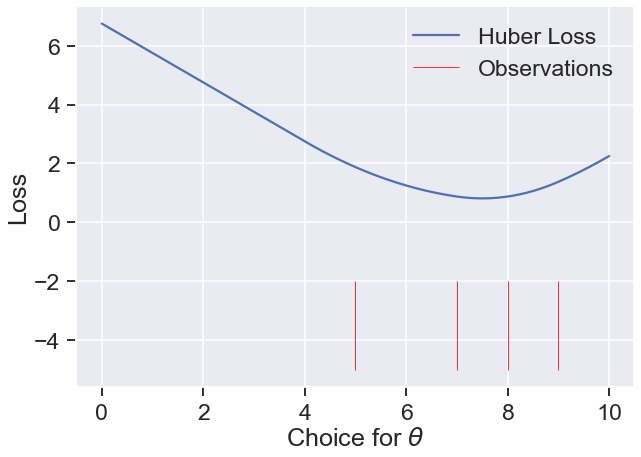

In [125]:
thetas = np.linspace(0, 10, 200)
loss = avg_huber_loss(thetas, data, 1)
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(data, -5, -2, colors="r", linewidth=0.8, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
#print("Minimizing Theta", thetas[np.argmin(loss)])
plt.savefig("l9_alpha1_huber_loss.png", dpi=300)

As you can tell, choosing a large alpha means that Huber loss would give a similar result to using L2 loss

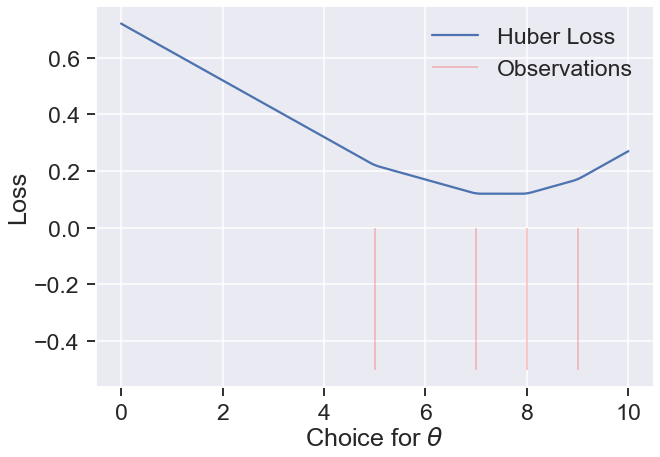

In [126]:
thetas = np.linspace(0, 10, 200)
loss = avg_huber_loss(thetas, data, 0.1)
plt.plot(thetas, loss, label="Huber Loss")
plt.vlines(data, -0.5, 0, colors="r", linewidth=0.4, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
#print("Minimizing Theta", thetas[np.argmin(loss)])
plt.savefig("l9_alphapt1_huber_loss.png", dpi=300)

Choosing a very small alpha makes the Huber loss a lot closer to the L1 loss

## Huber Loss Minimization

As loss functions get more and more complicated, finding an analytical solution to them because even more complicated. Yet, we often require extremely complex loss functions due to the nature of the data, and thus we require alternate methods to minimize a given loss function.

---
<br/><br/><br/> 

# Minimizing the Average Huber Loss Analytically 

Recall that the Huber loss has the form:

$$\Large
f(\theta) =\frac{1}{n}\sum_{i=1}^n 
\begin{cases} 
      \frac{1}{2}\left( y_i - \theta \right)^2 & \left| y_i - \theta \right| < \alpha \\
       \alpha \left(\left| y_i - \theta  \right| - \frac{\alpha}{2} \right) & \text{otherwise}
\end{cases}
$$

Taking the derivative we get:

$$\Large
\frac{\partial}{\partial \theta} f(\theta) =\frac{1}{n}\sum_{i=1}^n 
\begin{cases} 
      -\left(y_i - \theta  \right) & \left| \theta - y_i \right| < \alpha \\
        -\alpha  \, \textbf{sign}(y_i - \theta) & \text{otherwise}
\end{cases}
$$

Unfortunately this is difficult to solve analytically. However we can get a plot of what the derivative looks like


### Derivative at a single point
We can visualize the derivative at a single point and we'll know that for a single point (over here it is chosen to be 3), the derivative would be 0 when $\theta$ is 3. This makes sense since the absolute loss between the data-point 3, and $\theta = 3$ is 0.

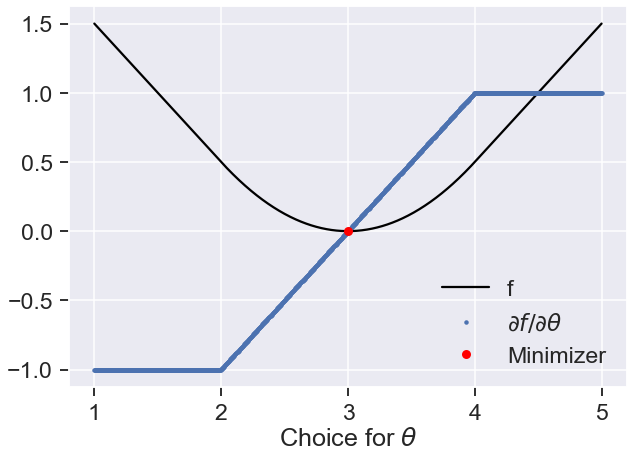

In [127]:
alpha =1.0
f = lambda theta: huber_loss(theta, 3, alpha = alpha)

def huber_loss_derivative_single(est, y_obs, alpha=1):
    d = abs_loss(est, y_obs)
    return np.where(d < alpha, 
                    est - y_obs,
                    alpha * np.sign(est-y_obs))

df = lambda theta: huber_loss_derivative_single(theta, 3.0, alpha=alpha)
thetas = np.linspace(1, 5, 1000)
plt.plot(thetas, f(thetas), 'k', label="f")
plt.plot(thetas, df(thetas), '.', label=r"$\partial f / \partial \theta$")
# plt.plot(thetas, ddf(thetas), '--', label=r"$\partial^2 f / \partial \theta^2$")
plt.plot([3],[0], 'ro', label="Minimizer")
plt.xlabel(r'Choice for $\theta$')
plt.legend(); 

### Derivative on 4 test points. 
Now we can introduce multiple values, i.e. a bigger dataset. An important thing to note here is that the loss function is never 0 when multiple data points are involved, this is because no single point can possibly have a distance of 0 from all the data points

For this example, we'll use the same data as before and visualize how the derivative changes with different values of $\alpha$. Notice that for the default $\alpha=1$ alpha value the curves look similar to the absolute loss but with smooth corners.

Minimizing Theta 7.474874371859297


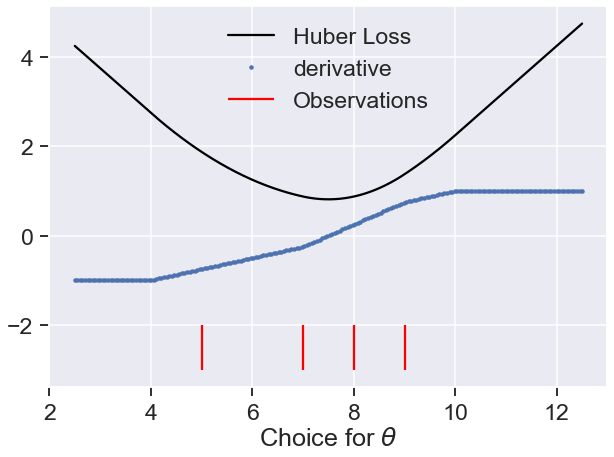

In [128]:
def huber_loss_derivative(est, data, alpha = 1):
    return np.mean(huber_loss_derivative_single(est, data, alpha))
    
thetas = np.linspace(2.5, 12.5, 200)
alpha = 1
plt.plot(thetas, avg_huber_loss(thetas, data, alpha), '-k', label="Huber Loss")
plt.plot(thetas, [huber_loss_derivative(u, data, alpha) for u in thetas], '.', label='derivative')
plt.vlines(data, -3, -2, colors="r", label="Observations")
plt.xlabel(r'Choice for $\theta$')
print("Minimizing Theta", thetas[np.argmin(avg_huber_loss(thetas, data, alpha))])
plt.legend(loc=9)
plt.savefig('l9_huber_4_pt_large_alpha.png', dpi=300)

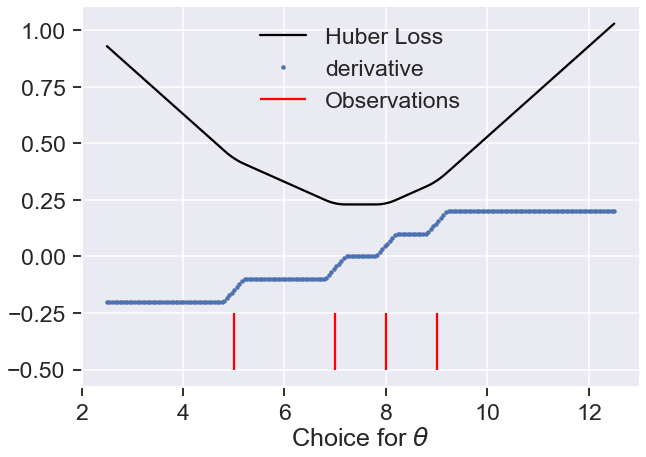

In [129]:
thetas = np.linspace(2.5, 12.5, 200)
alpha = 0.2
plt.plot(thetas, avg_huber_loss(thetas, data, alpha), '-k', label="Huber Loss")
plt.plot(thetas, [huber_loss_derivative(u, data, alpha) for u in thetas], '.', label='derivative')
plt.vlines(data, -0.5, -0.25, colors="r", label="Observations")
plt.xlabel(r'Choice for $\theta$')
plt.legend(loc=9)
#plt.savefig('l9_huber_4_pt_small_alpha.png', dpi=300)

All of this sounds well and good, but how can we use the derivative to minimize the loss, if we can not analytically solve it? Do Data Scientists always just draw a graph and point out where the minimum value is?

No, while this may seem possible with data that has single variables, it's not possible with multidimensional data. Thus, we use numerical minimization.

# Numerical Minimization

## Brute Force

We can also attempt to minimize our loss functions numerically instead of graphically. A very slow and terrible way would be manual guess-and-check. 

In [130]:
data = np.array([5, 7, 8, 9])

In [131]:
# Let's try with theta = 4
avg_squared_loss(4, data)

12.75

In [132]:
# Theta = 7 gives a smaller value, let's just choose this
avg_squared_loss(7, data)

2.25

A somewhat better approach is to use brute force to try out a bunch of thetas and return the one that yields the lowest loss.

In [133]:
def simple_minimize(loss_fn, observations, thetas):
    losses = [loss_fn(theta, observations) for theta in thetas]  
    return thetas[np.argmin(losses)]

In [134]:
simple_minimize(avg_squared_loss, data, np.linspace(0, 10, 20))

7.368421052631579

Visually, what we're doing is computing all the starred values below and then returning the $\theta$ that goes with the minimum value.

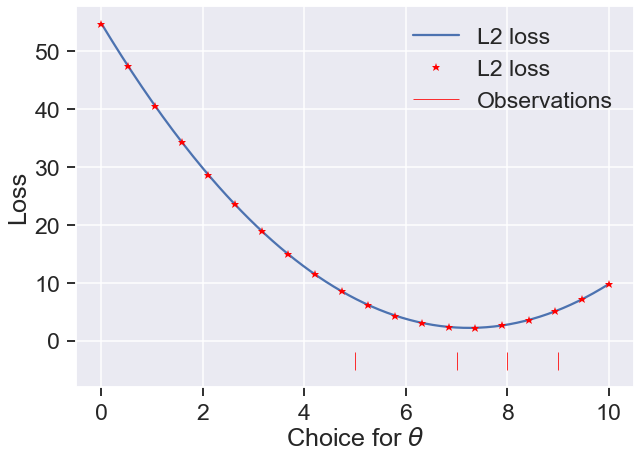

In [135]:
thetas = np.linspace(0, 10, 200)
sparse_thetas = np.linspace(0, 10, 20)

loss = avg_squared_loss(thetas, data)
sparse_loss = avg_squared_loss(sparse_thetas, data)

plt.plot(thetas, loss, label = "L2 loss")
plt.plot(sparse_thetas, sparse_loss, 'r*', label = "L2 loss")
plt.vlines(data, -5, -2, colors="r", linewidth=0.8, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l9_brute_force.png", dpi=300)

From our calculus based approach above, we know the actual answer is simply the mean of the data.

In [136]:
np.mean(data)

7.25

Note that `simple_minimize` off by a bit, and this is simply because the exact value 7.25 wasn't one of the guesses we tried.

We can repeat this same process to minimize the huber loss for our data set.

In [137]:
avg_huber_alpha_one = lambda theta, data: avg_huber_loss(theta, data, 1)
simple_minimize(avg_huber_alpha_one, data, np.linspace(0, 10, 10000))

7.4997499749975

Or visually:

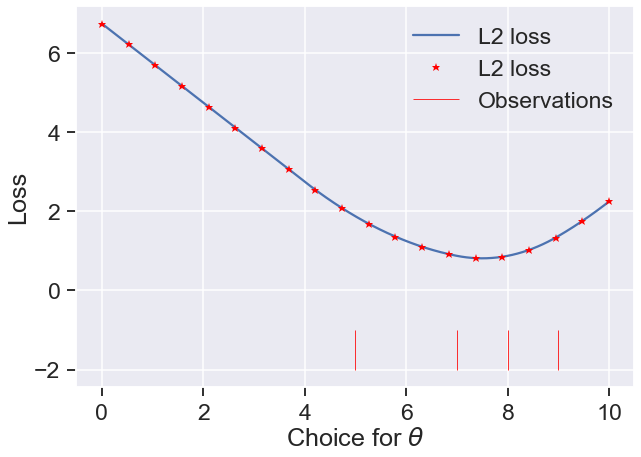

In [138]:
thetas = np.linspace(0, 10, 200)
sparse_thetas = np.linspace(0, 10, 20)

loss = avg_huber_alpha_one(thetas, data)
sparse_loss = avg_huber_alpha_one(sparse_thetas, data)

plt.plot(thetas, loss, label = "L2 loss")
plt.plot(sparse_thetas, sparse_loss, 'r*', label = "L2 loss")
plt.vlines(data, -2, -1, colors="r", linewidth=0.8, label="Observations")
plt.xlabel(r"Choice for $\theta$")
plt.ylabel(r"Loss")
plt.legend()
plt.savefig("l9_brute_force.png", dpi=300)

This basic approach is incredibly inefficient, and suffers from two major flaws:
1. If the minimum is outside our range of guesses for theta, the answer will be completely wrong.
2. Even if our range of gueseses is correct, if the guesses are too coarse, i.e. too far apart, our answer will be inaccurate.

In [139]:
# Over here we tried out 10000 thetas from 0 to 3
simple_minimize(avg_huber_alpha_one, data, np.linspace(0, 3, 10000))

3.0

In [140]:
# 100 thetas from 0 to 1000
simple_minimize(avg_huber_alpha_one, data, np.linspace(0, 1000, 100))

10.1010101010101

## Gradient Descent

Instead of choosing all of our guesses ahead of time, we can instead start from a single guess and try to iteratively improve on our loss. 

They key insight is this: Given that our loss functions are convex, we know that the derivative of the loss is always negative to the left of the solution, and always positive to the right of the solution.

Thus, the derivative tells us which way to go.

Minimizing Theta 7.474874371859297


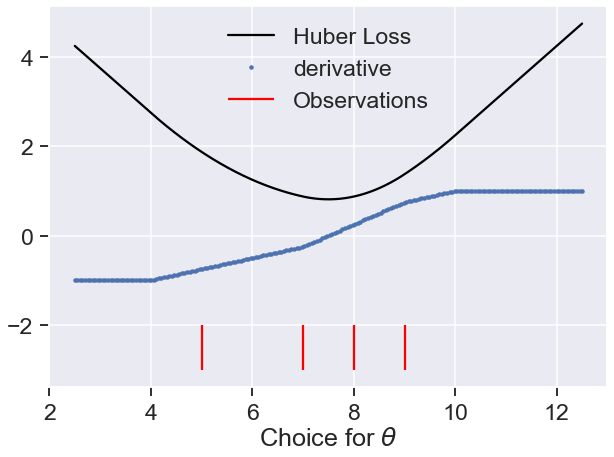

In [141]:
thetas = np.linspace(2.5, 12.5, 200)
alpha = 1
plt.plot(thetas, avg_huber_loss(thetas, data, alpha), '-k', label="Huber Loss")
plt.plot(thetas, [huber_loss_derivative(u, data, alpha) for u in thetas], '.', label='derivative')
plt.vlines(data, -3, -2, colors="r", label="Observations")
plt.xlabel(r'Choice for $\theta$')
print("Minimizing Theta", thetas[np.argmin(avg_huber_loss(thetas, data, alpha))])
plt.legend(loc=9)

In [142]:
huber_loss_derivative(0, data, 1)

-1.0

Since the derivative above is negative, we should go to the right.

In [143]:
huber_loss_derivative(4, data, 1)

-1.0

In [144]:
huber_loss_derivative(6, data, 1)

-0.5

In [145]:
huber_loss_derivative(9, data, 1)

0.75

In [146]:
huber_loss_derivative(8, data, 1)

0.25

In [147]:
huber_loss_derivative(7.5, data, 1)

0.0

Gradient descent is a more intelligent process than the one we did above. In particular, gradient descent creates its next guess based not only on the sign of the slope, but also its magnitude. Let's try the most naive possible approach and simply add the slope to our current guess, i.e.

$$
\theta^{(t+1)} = \theta^{(t)} - \frac{\partial}{\partial \theta} L(\theta^{(t)}, \textbf{y})
$$

Where $ \theta^{(t)} $ is the current estimate and $ \theta^{(t+1)} $ is the next estimate.

In [148]:
huber_loss_derivative(5, data, 1)

-0.75

In [149]:
# We moved 0.75 to the right
huber_loss_derivative(5.75, data, 1)

-0.5625

In [150]:
# 0.5625 to the right
huber_loss_derivative(6.3125, data, 1)

-0.421875

In [151]:
# 0.421875 to the right
huber_loss_derivative(6.734375, data, 1)

-0.31640625

In [152]:
# 0.31640625 to the right
huber_loss_derivative(7.05078125, data, 1)

-0.224609375

In [153]:
huber_loss_derivative(7.275390625, data, 1)

-0.1123046875

In [154]:
huber_loss_derivative(7.3876953125, data, 1)

-0.05615234375

In [155]:
huber_loss_derivative(7.44384765625, data, 1)

-0.028076171875

In [156]:
huber_loss_derivative(7.471923828125, data, 1)

-0.0140380859375

The following function simply applies what we just did in a function. We pass a function into gradient_descent (derivative function - df), we take a guess, apply the derivative to the guess, improve are guess, and do it $n$ number of times

In [157]:
def gradient_descent_v1(df, initial_guess, n):
    guesses = [initial_guess]
    guess = initial_guess
    while len(guesses) < n:
        guess = guess - df(guess)
        guesses.append(guess)
    return np.array(guesses)

In [158]:
# This defines the derivative function we are passing to gradient descent
hld_example = lambda theta: huber_loss_derivative(theta, data, 1)

In [159]:
gradient_descent_v1(hld_example, 5, 50)

array([5.        , 5.75      , 6.3125    , 6.734375  , 7.05078125,
       7.27539062, 7.38769531, 7.44384766, 7.47192383, 7.48596191,
       7.49298096, 7.49649048, 7.49824524, 7.49912262, 7.49956131,
       7.49978065, 7.49989033, 7.49994516, 7.49997258, 7.49998629,
       7.49999315, 7.49999657, 7.49999829, 7.49999914, 7.49999957,
       7.49999979, 7.49999989, 7.49999995, 7.49999997, 7.49999999,
       7.49999999, 7.5       , 7.5       , 7.5       , 7.5       ,
       7.5       , 7.5       , 7.5       , 7.5       , 7.5       ,
       7.5       , 7.5       , 7.5       , 7.5       , 7.5       ,
       7.5       , 7.5       , 7.5       , 7.5       , 7.5       ])

In [160]:
def squared_loss_derivative_single(est, y_obs):
    return 2*(est - y_obs)
    
def squared_loss_derivative(est, data):
    return np.mean(squared_loss_derivative_single(est, data))    

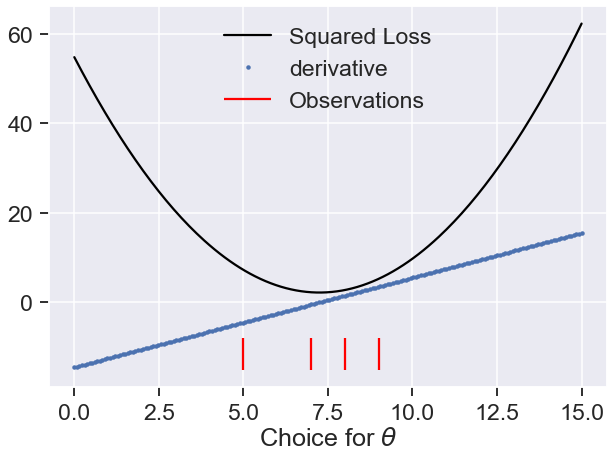

In [161]:
thetas = np.linspace(0, 15, 200)
plt.plot(thetas, avg_squared_loss(thetas, data), '-k', label="Squared Loss")
plt.plot(thetas, [squared_loss_derivative(u, data) for u in thetas], '.', label='derivative')
plt.vlines(data, -15, -8, colors="r", label="Observations")
plt.xlabel(r'Choice for $\theta$')
plt.legend(loc=9)
plt.savefig("l9_squared_loss_derivative.png", dpi=300)

This is what the derivative of the squared loss function looks like. We seem to be running into a problem....

### Problems with simple gradient descent

In [162]:
squared_loss_derivative(0, data)

-14.5

In [163]:
squared_loss_derivative(14.5, data)

14.5

In [164]:
sld_example = lambda theta: squared_loss_derivative(theta, data)
gradient_descent_v1(sld_example, 0, 10)

array([ 0. , 14.5,  0. , 14.5,  0. , 14.5,  0. , 14.5,  0. , 14.5])

As you can see, there is a problem here. The value for the derivative of the squared loss function for an initial guess of 0 is -14.5, so we move 14.5 to the right. But the derivative of 14.5 is +14.5, so we move 14.5 to the left. This brings us back to square one, and we can repeat this indefinitely and keep cycling between 0 and 14.5

Another version of gradient descent is to multiply the value of the derivative with a value of $\alpha$ before subtracting from the guess

In [165]:
def gradient_descent_v2(df, initial_guess, n, alpha):
    guesses = [initial_guess]
    guess = initial_guess
    while len(guesses) < n:
        #print(alpha * df(guess))
        guess = guess - alpha * df(guess)
        guesses.append(guess)
    return np.array(guesses)

In [166]:
sld_example = lambda theta: squared_loss_derivative(theta, data)
gradient_descent_v2(sld_example, 0, 10, 0.4)

array([0.        , 5.8       , 6.96      , 7.192     , 7.2384    ,
       7.24768   , 7.249536  , 7.2499072 , 7.24998144, 7.24999629])

Introducing alpha into gradient descent has significantly improved our results even for squared_loss_derivative

### Using scipy to minimize a function

Note that we have not discussed how to decide when gradient descent is done. We'll leave this for you to learn a later time.

Function optimization is such a common problem that tools have been written to do all this work for us. For example, `scipy` provides us with the relatively user friendly `scipy.optimize.minimize` function.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

All we have to do is provide the function, the deriviative of the function, and a starting guess, and it will use the gradient to find the solution. Note, the actual algorithm used by `minimize` is something more sophisticated than gradient descent called BFGS that we will not discuss in our course.

In [167]:
def squared_loss_derivative(ests, data):
    return np.array([np.mean(squared_loss_derivative_single(est, data)) for est in ests])

from scipy.optimize import minimize
data = np.array([5, 7, 8, 9])
f = lambda theta: avg_squared_loss(theta, data)
df = lambda theta: squared_loss_derivative(theta, data)
minimize(f, 0.0, jac=df)

      fun: 2.1875
 hess_inv: array([[0.5]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([7.25])

Strictly speaking, minimize doesn't need the derivative, though you're likely to get better and faster results if you provide it.

In [168]:
minimize(f, 0.0)

      fun: 2.187500000000008
 hess_inv: array([[0.49999999]])
      jac: array([-1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([7.24999991])

## Multi Dimensional Models
So far we've been working with just 4 observations, that too of just one variable. Real data looks nothing like this. Our model initially was simply that $y = \theta$. Here $y$ is now percentage_tip

In [169]:
#tips datset
data = sns.load_dataset("tips")
data['pcttip'] = data['tip']/data['total_bill'] * 100
data.head()

,total_bill,tip,sex,smoker,day,time,size,pcttip
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


# Improving the Model

Initially we had a very simple model that the percentage tip is constant:

$$\Large
\text{percentage tip} = \theta
$$

We then defined several loss functions and used those to estimate the value of $\theta$.  How can we improve this model? Recall that we do have additional information:

In [170]:
data.head()

,total_bill,tip,sex,smoker,day,time,size,pcttip
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


One idea is to model the tip as having a linear dependence on the total bill size.

$\texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{total bill}$

This model is essentially the same as $y = mx + x$ that we have been using for line-fitting for so long

This idea is supported by the plot below.

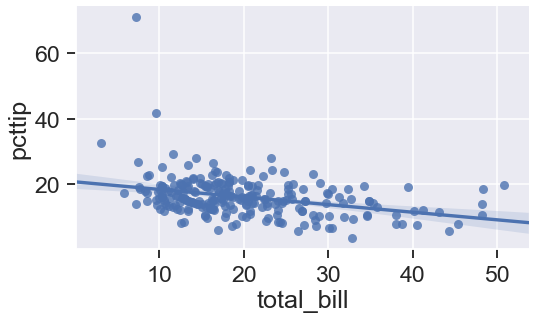

In [171]:
sns.lmplot(x = "total_bill", y = "pcttip", data = data, aspect=1.6)
plt.savefig("ptip_total_bill.pdf")

In [172]:
# We can implement this model as below
def f(theta, total_bill):
    return theta[0] + theta[1] * total_bill

Now, instead of just one theta that we need to find the best value for, we have two thetas. Our loss functions can also easily incorporate these two thetas. The only difference is that the $estimate$ is now not just $\theta$, but it is rather a function of two thetas, as defined above.

Let's try to plot the various different loss functions with respect to both thetas and try to see how the graph changes

In [173]:
def squared_loss(est, y_obs):
    return (est - y_obs)**2

def abs_loss(est, y_obs):
    return np.abs(y_obs - est)

def huber_loss(est, y_obs, alpha = 1):
    d = abs_loss(est, y_obs)
    return np.where(d < alpha, 
                    squared_loss(est, y_obs) / 2.0,
                    alpha * (d - alpha / 2.0))

#We can define our l1, l2, and huber loss functions on tips as below.
def l1_tips(theta):
    return np.mean(abs_loss(f(theta, data['total_bill']), data['pcttip']).values)

def l2_tips(theta):
    return np.mean(squared_loss(f(theta, data['total_bill']), data['pcttip']).values)

def huber_tips(theta):
    return np.mean(huber_loss(f(theta, data['total_bill']), data['pcttip']))
#minimize(l1, np.array([0.0,0.0]))
#minimize(l2, np.array([0.0,0.0]))
#minimize(huber, np.array([0.0,0.0]))

In [178]:
# Make range of values for thetas
uvalues = np.linspace(16,22,70)
vvalues = np.linspace(-.5,0,70)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))


# res = {}

#replace first line with this to see all 3 loss functions
#for loss_name, loss in [("L1", l1_tips), ("L2", l2_tips), ("Huber", huber_tips)]:


for loss_name, loss in [("L1", l1_tips)]:
    loss_values = np.array([loss(t) for t in thetas.T])
    
    loss_surface = go.Surface(name=loss_name,
            x=u, y=v, z=np.reshape(loss_values, u.shape),
            contours=dict(z=dict(show=True, color="gray", project=dict(z=True)))
        )

    scene=go.Scene(
            xaxis=go.XAxis(title='w0'),
            yaxis=go.YAxis(title='w1'),
            aspectratio=dict(x=2.,y=2., z=1.), 
    #         camera=dict(eye=dict(x=-2, y=-2, z=2))
        )

    layout = go.Layout(
        autosize=True,
        width=800,
        height=600,
        scene = scene
    )
    ind = np.argmin(loss_values)
    optimal_point = go.Scatter3d(name = "Optimal Point for " + loss_name,
        x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
        z = [loss_values[ind]],
        marker=dict(size=10, color="red"))
    py.iplot(go.Figure(data=[loss_surface, optimal_point], layout = layout))

## Multi-Dimensional Gradient Descent
Now that we have more dimensions, and more thetas, how do we calculate the derivative of the loss function? How do we take the steps to find the local minima?

Simple, you take the derivative of the model loss function with respect to $\theta1$, and use the value of this derivative to change the guess for $\theta1$. You repeat the same thing with $\theta2$


In [181]:
def fmgd(theta):
    return theta[0]**2 - 12*theta[0] + theta[1]**2 + 2*theta[1]
    
def gradient_fmgd(theta):
    dth1 = 2*theta[0] - 12
    dth2 = 2*theta[1] + 2
    return np.array([dth1, dth2])

In [183]:
# To visualize fmgd
uvalues = np.linspace(-5,15,100)
vvalues = np.linspace(-10,10,100)
(u,v) = np.meshgrid(uvalues, vvalues)
thetas = np.vstack((u.flatten(),v.flatten()))
z_values = np.array([fmgd(t) for t in thetas.T])

z_surface = go.Surface(name="z",
        x=u, y=v, z=np.reshape(z_values, u.shape),
        contours=dict(z=dict(show=True, color="gray", project=dict(z=True)))
    )

scene=go.Scene(
        xaxis=go.XAxis(title='theta0'),
        yaxis=go.YAxis(title='theta1'),
        aspectratio=dict(x=2.,y=2., z=1.), 
#         camera=dict(eye=dict(x=-2, y=-2, z=2))
    )

layout = go.Layout(
    autosize=True,
    width=800,
    height=600,
    scene = scene
)
ind = np.argmin(z_values)
optimal_point = go.Scatter3d(name = "Optimal Point",
    x = [thetas.T[ind,0]], y = [thetas.T[ind,1]], 
    z = [z_values[ind]], 
    marker=dict(size=10, color="red"))
py.iplot(go.Figure(data=[z_surface, optimal_point], layout = layout))

In [184]:
z_contour = go.Contour(name="fmgd",
        x=uvalues, y=vvalues, z=np.reshape(z_values, u.shape),
        colorscale='Viridis', reversescale=True
    )

py.iplot(go.Figure(data=[z_contour], layout = layout))

In [185]:
# Start with initial guesses of theta1 = 0 and theta2 = 0
guess = np.array([0, 0])

In [186]:
gradient_fmgd([0, 0])

array([-12,   2])

In [187]:
gradient_fmgd(guess) + guess

array([-12,   2])

In [188]:
theta_path = gradient_descent_v2(gradient_fmgd, np.array([0, 0]), 100, 0.2)

In [189]:
theta_points = go.Scatter(name="Theta Values", x=theta_path[:,0], y=theta_path[:,1],
                          mode="lines+markers")

z_contour = go.Contour(name="fmgd",
        x=uvalues, y=vvalues, z=np.reshape(z_values, u.shape),
        colorscale='Viridis', reversescale=True
    )



py.iplot(go.Figure(data=[z_contour, theta_points], layout = layout))

Now you can see how the guess moves on the error surface, slowly coming towards the minima. The value on which this happens is $\theta1 = 6$, $theta2 = -1$

Or using scipy's `minimize`:

In [190]:
from scipy.optimize import minimize
minimize(fmgd, np.array([0, 0]), jac=gradient_fmgd)

      fun: -37.0
 hess_inv: array([[0.51351351, 0.08108108],
       [0.08108108, 0.98648649]])
      jac: array([ 0.00000000e+00, -2.22044605e-15])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([ 6., -1.])

## "Improving the Model"

We could get extra fancy and start trying to include additional features. More features also means more thetas 

$\texttt{percentage tip} = \theta_1 + \theta_2 * \texttt{is Male} + \theta_3 *\texttt{is Smoker} + \theta_4 * \texttt{table size}$

In [191]:
data.head()

,total_bill,tip,sex,smoker,day,time,size,pcttip
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


In [192]:
def f(theta, data):
    return (
        theta[0] + 
        theta[1] * (data['sex'] == 'Male') +
        theta[2] * (data['smoker'] == "Yes") +
        theta[3] * data['size']
    )

In [193]:
def l2(theta):
    return np.mean(squared_loss(f(theta, data), data['pcttip']).values)

minimize(l2, np.zeros(4))

      fun: 36.25888793122608
 hess_inv: array([[ 5.00852276, -1.03468734, -1.13297213, -1.36869473],
       [-1.03468734,  2.06166674,  0.00679159, -0.11857307],
       [-1.13297213,  0.00679159,  2.08462848,  0.14029876],
       [-1.36869473, -0.11857307,  0.14029876,  0.55080528]])
      jac: array([3.81469727e-06, 3.33786011e-06, 4.76837158e-07, 8.10623169e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([18.73866929, -0.73513124,  0.16122391, -0.87437012])

In [194]:
def l1(theta):
    return np.mean(abs_loss(f(theta, data), data['pcttip']).values)

minimize(l1, np.zeros(4))

      fun: 3.90957158852356
 hess_inv: array([[ 443.57329609, -215.55179077, -211.52560242, -109.7383045 ],
       [-215.55179077,  104.77953797,  102.80962477,   53.31466531],
       [-211.52560242,  102.80962477,  100.96345597,   52.31890909],
       [-109.7383045 ,   53.31466531,   52.31890909,   27.15457305]])
      jac: array([0.00750431, 0.00340596, 0.00340596, 0.01979941])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1104
      nit: 31
     njev: 182
   status: 2
  success: False
        x: array([18.02471408, -0.72038142, -0.9579457 , -0.77126898])

In [195]:
def huber(theta):
    return np.mean(huber_loss(f(theta, data), data['pcttip']))

minimize(huber, np.zeros(4))

      fun: 3.4476306812527757
 hess_inv: array([[ 77.24012512, -19.71060902, -26.073196  , -20.40690306],
       [-19.71060902,  20.85365616,   4.85116291,   2.01663757],
       [-26.073196  ,   4.85116291,  28.8990574 ,   5.65213441],
       [-20.40690306,   2.01663757,   5.65213441,   6.76874477]])
      jac: array([-1.19209290e-07, -8.94069672e-08, -1.19209290e-07, -1.78813934e-07])
  message: 'Optimization terminated successfully.'
     nfev: 150
      nit: 21
     njev: 25
   status: 0
  success: True
        x: array([18.53021329, -0.90174037, -0.87843472, -0.84144212])

We could use the same loss framework as before and compute the best parameters for each model and then choose the model with the smallest average loss. 

_**Warning:** There are some issues with this approach that we will revisit later_